# AnoGAN

In [1]:
from model.dcgan import DCGAN
from model.anogan import AnoGAN

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, Input, MaxPool2D, UpSampling2D, BatchNormalization, Activation, Dropout, ZeroPadding2D
%matplotlib inline

In [41]:
EPOCHS = 100
NOISE_DIM = 100

## Dataset

In [3]:
TRAIN_PATH = r"C:\Users\filip\Desktop\Universita\Laboratorio di Intelligenza Artificiale\hazelnut\train"
TEST_PATH = r"C:\Users\filip\Desktop\Universita\Laboratorio di Intelligenza Artificiale\hazelnut\test"

training_set = tf.keras.utils.image_dataset_from_directory(TRAIN_PATH, image_size = (64, 64), batch_size = 32)
test_set = tf.keras.utils.image_dataset_from_directory(TEST_PATH, image_size = (64, 64))

Found 391 files belonging to 1 classes.
Found 110 files belonging to 5 classes.


### Data Augmentation

In [4]:
translation_layer = tf.keras.layers.RandomTranslation(0.2, 0.2, input_shape = (64, 64, 3))
rotation_layer = tf.keras.layers.RandomRotation(0.2, input_shape = (64, 64, 3))
zoom_layer = tf.keras.layers.RandomZoom((-0.3, 0.3), input_shape = (64, 64, 3))
brightness_layer = tf.keras.layers.RandomBrightness(0.2, input_shape = (64, 64, 3))

translated_ts = training_set.map(lambda x, y: (translation_layer(x, training=True), y))

#Original + translated
augmented_ts = training_set.concatenate(translated_ts)

rotated_ts = augmented_ts.map(lambda x, y: (rotation_layer(x, training = True), y))

#Original + translated + rotated + translated and rotated
augmented_ts = augmented_ts.concatenate(rotated_ts)

zoomed_ts = augmented_ts.map(lambda x, y: (zoom_layer(x, training = True), y))

#Original + translated + rotated + zoomed + translated and rotated + translated and zoomed + 
#rotated and zoomed + translated and rotated and zoomed
augmented_ts = augmented_ts.concatenate(zoomed_ts)

brightness_ts = augmented_ts.map(lambda x, y: (brightness_layer(x, training = True), y))

augmented_ts = augmented_ts.concatenate(brightness_ts)

In [5]:
len(augmented_ts)

208

In [6]:
ts_size = len(augmented_ts) #6256

In [ ]:
augmented_ts = augmented_ts.batch(32)

In [ ]:
print(augmented_ts)

In [ ]:
#augmented_ts = augmented_ts.shuffle(buffer_size = ts_size, reshuffle_each_iteration = True)

### Normalizzazione

In [7]:
normalization_layer = tf.keras.layers.Rescaling(scale = (1./127.5), offset = -1)

normalized_training_set = training_set.map(lambda x, y: (normalization_layer(x), y))
normalized_test_set = test_set.map(lambda x, y: (normalization_layer(x), y))

In [8]:
gan = DCGAN()

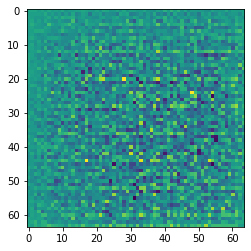

In [9]:
img = gan.generator(tf.random.normal([1,100]))

plt.imshow(img[0, :, :, 0])
plt.show()

In [10]:
print(gan.discriminator(img))

tf.Tensor([[-2.6588361e-05]], shape=(1, 1), dtype=float32)


In [88]:
#Train
#gan.restore()
disc_loss, gen_loss = gan.train(normalized_training_set, EPOCHS)

Epoch 1  -  Generator Loss: 0.542	Discriminator Loss: 2.008
Epoch 2  -  Generator Loss: 0.532	Discriminator Loss: 1.936
Epoch 3  -  Generator Loss: 0.517	Discriminator Loss: 1.871
Epoch 4  -  Generator Loss: 0.540	Discriminator Loss: 1.848
Epoch 5  -  Generator Loss: 0.522	Discriminator Loss: 1.734
Epoch 6  -  Generator Loss: 0.485	Discriminator Loss: 1.876
Epoch 7  -  Generator Loss: 0.551	Discriminator Loss: 1.882
Epoch 8  -  Generator Loss: 0.531	Discriminator Loss: 1.903
Epoch 9  -  Generator Loss: 0.641	Discriminator Loss: 1.881
Epoch 10  -  Generator Loss: 0.624	Discriminator Loss: 2.050
Epoch 11  -  Generator Loss: 0.578	Discriminator Loss: 2.050
Epoch 12  -  Generator Loss: 0.544	Discriminator Loss: 2.035
Epoch 13  -  Generator Loss: 0.583	Discriminator Loss: 1.785
Epoch 14  -  Generator Loss: 0.604	Discriminator Loss: 1.662
Epoch 15  -  Generator Loss: 0.462	Discriminator Loss: 1.927
Epoch 16  -  Generator Loss: 0.452	Discriminator Loss: 2.224
Epoch 17  -  Generator Loss: 0.64

In [ ]:
gan.save()

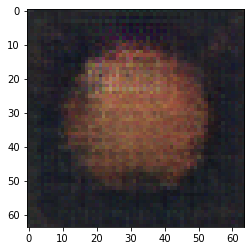

In [91]:
generated_img = gan.generator(tf.random.normal([1, 100]))
i = np.array((generated_img[0] * 127.5) + 127.5 , np.int32)
plt.imshow(i)
plt.show()

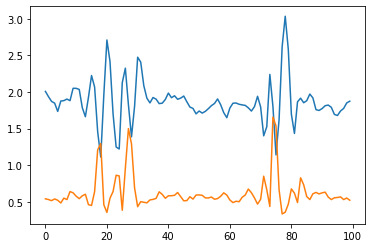

In [92]:
plt.plot(disc_loss)
plt.plot(gen_loss)
plt.show()

In [ ]:
gan.generator.summary()

In [93]:
anogan = AnoGAN(gan)

In [94]:
test_image = []
for images, labels in normalized_test_set:
    for i in range(1):
        test_image = images[i].numpy()
    break
test_image = np.array([test_image])
anomaly_score, similar_img = anogan.compute_anomaly_score(test_image)

1/1 [==============================] - 0s 225ms/step


In [95]:
print(anomaly_score)

1213.4893798828125


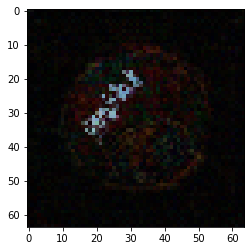

In [96]:
t = np.array((test_image[0] * 127.5) + 127.5, np.int32)
s = np.array((similar_img[0] * 127.5) + 127.5, np.int32)
plt.imshow(abs(t-s))
plt.show()

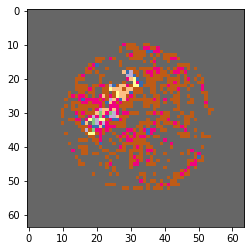

In [99]:
plt.imshow(abs(similar_img[0, :, :, 0]-test_image[0, : ,: ,0]), cmap="Accent_r")

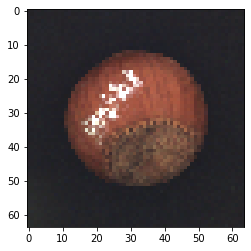

In [98]:
plt.imshow(t, cmap="Accent_r")